In [14]:
import os
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import random as rd

In [15]:
def readFile(folderPath):    
    with open(folderPath, 'r') as f:
        fileContents = f.readlines()
    return fileContents

In [16]:
def fillInfoFromContents(fileContents, info):
    for i, content in enumerate(fileContents):
        if i == 0:
            info['Instance Name'].append(content.split()[2])
        elif i == 1:
            info['Number of Nodes'].append([int(word) for word in content.split() if word.isdigit()][0])
        elif i == 2:
            info['Required Edges'].append([int(word) for word in content.split() if word.isdigit()][0])
        elif i == 3:
            c = [int(word) for word in content.split() if word.isdigit()][0]
        elif i == 6:
            info['Capacity'].append([int(word) for word in content.split() if word.isdigit()][0])
        elif i == 9:
            info['Depot Nodes'].append([int(word) for word in content.split() if word.isdigit()])
            info['Number of Depot Nodes'].append(len(info['Depot Nodes'][-1]))
        
    info['Number of Edges'].append(c + info['Required Edges'][-1])

In [17]:
def readAndStoreInstanceInfo(folderPath):
    info = {'Instance Name' : [],
            'Number of Nodes' : [],
            'Number of Edges' : [],
            'Required Edges' : [],
            'Capacity' : [],
            'Number of Depot Nodes' : [],
            'Depot Nodes' : []}
    for i, file in enumerate(os.listdir(folderPath)):
        if file.endswith(".txt"):
            file_path = f"{folderPath}/{file}"
            fileContents = readFile(file_path)
            fillInfoFromContents(fileContents, info)

    df = pd.DataFrame(data=info,columns=['Instance Name','Number of Nodes', 'Number of Edges',
                                     'Required Edges', 'Capacity', 'Number of Depot Nodes', 'Depot Nodes'])
    print(df.columns)
    df.to_csv("DeArmon_dataset_info.csv")
    df.sort_values(by='Number of Edges', ascending=False)
    return info

In [7]:
def createGraphfromFile(file, info, index):
    fileContents = readFile(file)
    s = ["LIST_REQ_EDGES :\n", "LIST_NOREQ_EDGES :\n"]
    startProcessing = False
    startNode = []
    endNode = []
    edgeWeight = []
    i = 0
    for contents in fileContents:
        if contents == s[i] and startProcessing:
            startProcessing = False
            break

        if startProcessing:
            startNode.append([int(letters) for word in contents.split() for letters in word.split(",") if letters.isdigit()][0])
            endNode.append([int(letters) for word in contents.split() for letters in word.split(",") if letters.isdigit()][1])
            edgeWeight.append([int(letters) for word in contents.split() for letters in word.split(",") if letters.isdigit()][2])

        if contents == s[i]:
            startProcessing = True
            i += 1
    requiredEdges = []
    for i in range(info['Required Edges'][index]):
        requiredEdges.append([startNode[i], endNode[i]])
#     createGraph(info['Depot Nodes'][index], requiredEdges, info['Number of Nodes'][index], startNode, endNode, edgeWeight)
    return startNode, endNode, edgeWeight

In [8]:
def createGraph(depotNodes ,requiredEdges, numNodes, s, t, weights, show=True):
    G = nx.Graph()
    edges = []
#     pos = {}
#     reqPos = {}
#     s = [1, 1, 2, 2, 3, 3, 4, 4, 4, 5, 6, 7]
#     t = [2, 3, 4, 6, 4, 5, 5, 7, 6, 8, 7, 8]
#     weights = [2.3, 2, 3, 1.5, 3.2, 2.2, 3.8, 2.6, 2.2, 2.8, 1.8, 0.8]
#     xData = [-2, -0.5, -1,   0, 1,  1.5, 2,   2.5];
#     yData = [ 0, -2,    2.5, 0, 3, -2,   0.3, 1.5];
    
    for i in range(len(s)):
        edges.append((s[i], t[i], weights[i]))
    
    for i in range(1, numNodes+1):
        G.add_node(i)
#         pos[i] =(xData[i-1], yData[i-1])
    pos = nx.spring_layout(G)
    node_color = ['y']*int(G.number_of_nodes())
    depot_node_color = node_color
    for i in range(1, len(node_color)+1):
        if i in depotNodes:
            depot_node_color[i-1] = 'g'
            
    G.add_weighted_edges_from(edges)
    labels = nx.get_edge_attributes(G,'weight')
    nx.draw_networkx(G,pos, node_color = node_color)
    nx.draw_networkx(G,pos, node_color = depot_node_color)
    nx.draw_networkx_edges(G, pos, edgelist=requiredEdges, width=3, alpha=0.5,
                                        edge_color="r")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    if show:
        plt.figure(1)
#         plt.show()
    return G,pos, depot_node_color

In [9]:
folderPath = '../CARP_datasets/DeArmon_gdb-IF/'
info = readAndStoreInstanceInfo(folderPath)
folderPath = '../CARP_datasets/DeArmon_gdb-IF/gdb-IF-01.txt'
startNode, endNode, edgeWeight = createGraphfromFile(folderPath, info, 0)
print(startNode, endNode)
# for i, file in enumerate(os.listdir(folderPath)):
#     if file.endswith(".txt"):
#         file_path = f"{folderPath}/{file}"
#         print(file_path)
#         createGraphfromFile(file_path, info, i)
# print(info['Capacity'])

[1, 1, 1, 1, 1, 2, 2, 2, 3, 3, 5, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10] [2, 4, 7, 10, 12, 3, 4, 9, 4, 5, 6, 11, 12, 7, 12, 8, 12, 10, 11, 10, 11, 11]


In [12]:
def creatingIcyRoadInstance(file, info, index, startNode, endNode, edgeWeight):
    newDepotNodes = []
    requiredEdgeIndexes = []
    newRequiredEdges = []
    count = 0
    while count <= (info['Number of Nodes'][index]//5):
        node = rd.randint(0, info['Number of Nodes'][index])
        if node not in newDepotNodes:
            newDepotNodes.append(node)
            count += 1
    count = 0
    while count <= (info['Number of Edges'][index]//3):
        edge = rd.randint(0, info['Number of Edges'][index])
        if edge not in requiredEdgeIndexes:
            requiredEdgeIndexes.append(edge)
            count += 1
    print(max(edgeWeight))
    for i in range(info['Number of Edges'][index]):
        if i in requiredEdgeIndexes:
            newRequiredEdges.append([startNode[i], endNode[i]])
    createGraph(newDepotNodes, newRequiredEdges, info['Number of Nodes'][index], startNode, endNode, edgeWeight)
    plt.savefig('../IcyRoad Instances from DeArmon\icy_road_' + info['Instance Name'][index] + '.png')
    plt.show()

20


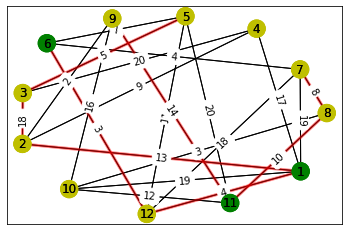

20


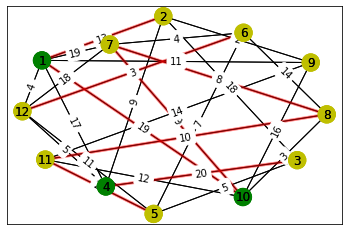

20


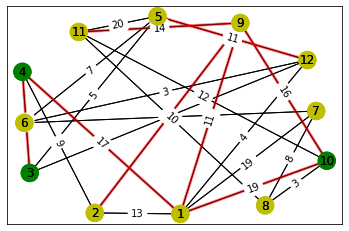

20


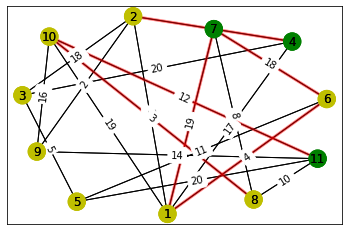

22


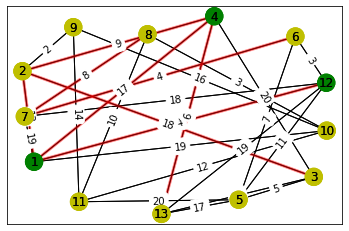

22


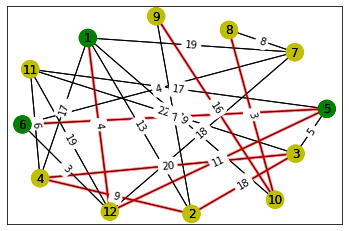

20


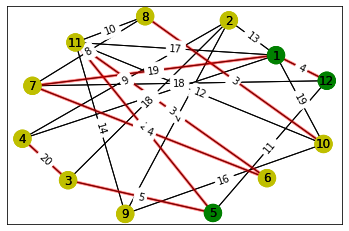

9


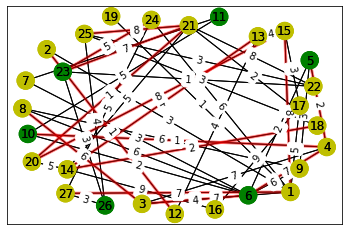

9


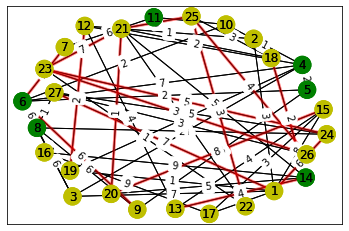

19


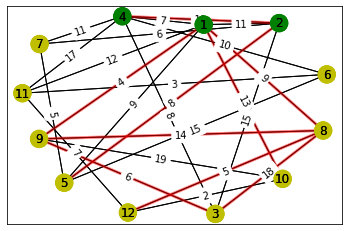

19


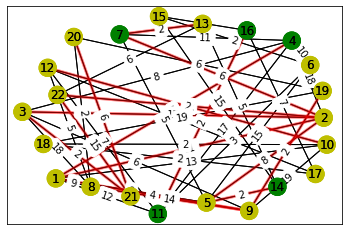

30


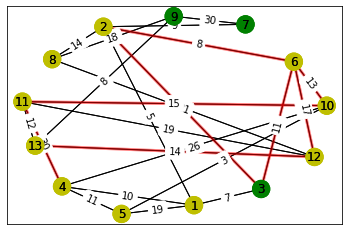

99


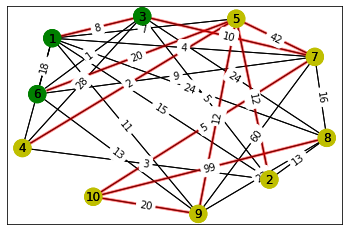

8


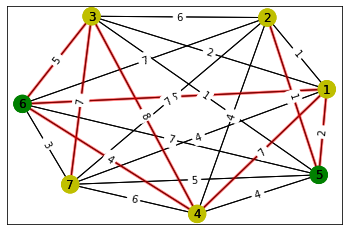

6


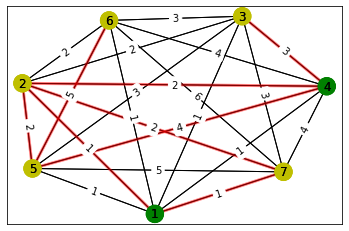

8


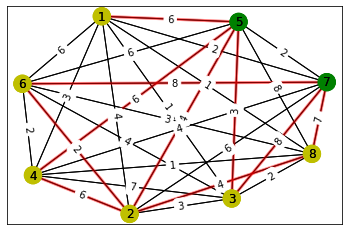

7


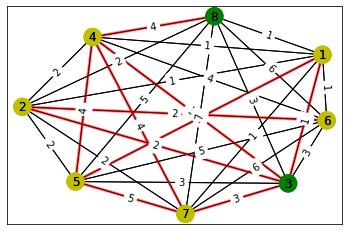

8


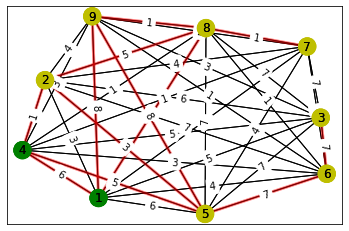

9


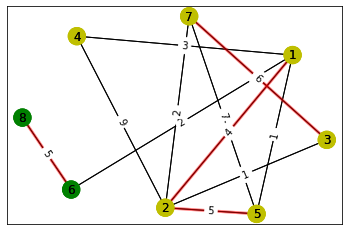

9


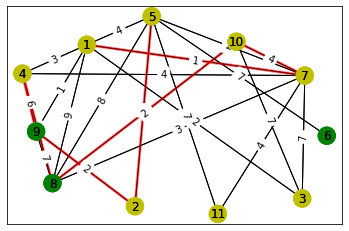

9


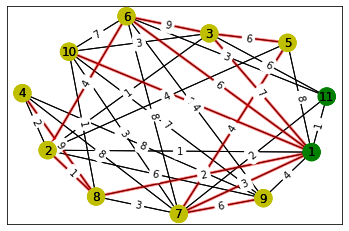

9


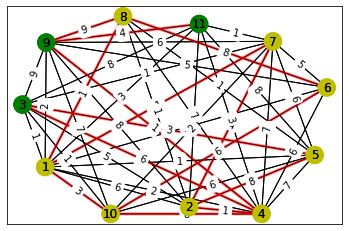

8


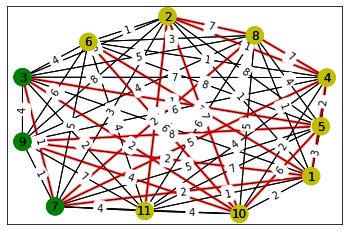

In [13]:
folderPath = '../CARP_datasets/DeArmon_gdb-IF'
for i, file in enumerate(os.listdir(folderPath)):
    if file.endswith(".txt"):
        file_path = f"{folderPath}/{file}"
        startNode, endNode, edgeWeight = createGraphfromFile(file_path, info, i)
        creatingIcyRoadInstance(file_path, info, i, startNode, endNode, edgeWeight)